In [1]:
import numpy as np
import cv2
import h5py
import time

import matplotlib.pyplot as plt
from tqdm.notebook import trange

# Loading simulation data

In [2]:
f = h5py.File("/storage/rando/data/nose_data.mat")
reading_time = time.time()
nose_data = np.asarray(f["nose"])
reading_time = time.time() - reading_time
print("[--] Data read in {}s!".format(round(reading_time, 4)))
f.close()

[--] Data read in 48.0794s!


In [3]:
f = h5py.File("/storage/rando/data/ground_data.mat")
reading_time = time.time()
ground_data = np.asarray(f["ground"])
reading_time = time.time() - reading_time
print("[--] Data read in {}s!".format(round(reading_time, 4)))
f.close()

[--] Data read in 48.479s!


# Resizing data and treshold

In [4]:
tresh = 3e-6

In [5]:
nose_resized = []
for i in trange(nose_data.shape[0]):
    arr = np.zeros((61,361))
    arr[15:46,60:181] = cv2.resize(nose_data[i], dsize=(121,31))
    nose_resized.append(arr)

nose_resized = np.array(nose_resized) > tresh

  0%|          | 0/2600 [00:00<?, ?it/s]

In [6]:
ground_resized = []
for i in trange(ground_data.shape[0]):
    arr = np.zeros((61,361))
    arr[15:46,60:181] = cv2.resize(ground_data[i], dsize=(121,31))
    ground_resized.append(arr)

ground_resized = np.array(ground_resized) > tresh

  0%|          | 0/2600 [00:00<?, ?it/s]

# Overwriting Simulation

In [7]:
import sys
sys.path.append('../..')
from src.pomdp import *

In [8]:
class RealSimulation(Simulation):
    def __init__(self, model: Model) -> None:
        self.iter = None
        super().__init__(model)


    def initialize_simulation(self, start_state: int | None = None) -> int:
        self.iter = 0
        return super().initialize_simulation(start_state)


    def run_action(self, a: int) -> tuple[int | float, int]:
        r,_ = super().run_action(a)

        x,y = self.model.get_coords(self.agent_state)
        o = 1 if (nose_resized if a == 5 else ground_resized)[self.iter, x, y] else 0

        self.iter += 1
        return (r,o)

# Gather model and VF

In [9]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')
vf = ValueFunction.load_from_file('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/ValueFunctions/run-3-VF.gzip', model)

# Simulation

In [10]:
a = Agent(model, vf)

In [14]:
hist = a.simulate(RealSimulation(model), start_state=(361*30)+300)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 29.52127
	- Steps: 638
	- Total rewards: 1.0
	- End state: s_30_60


# Plot Result

In [15]:
from viz_functions import plot_steps

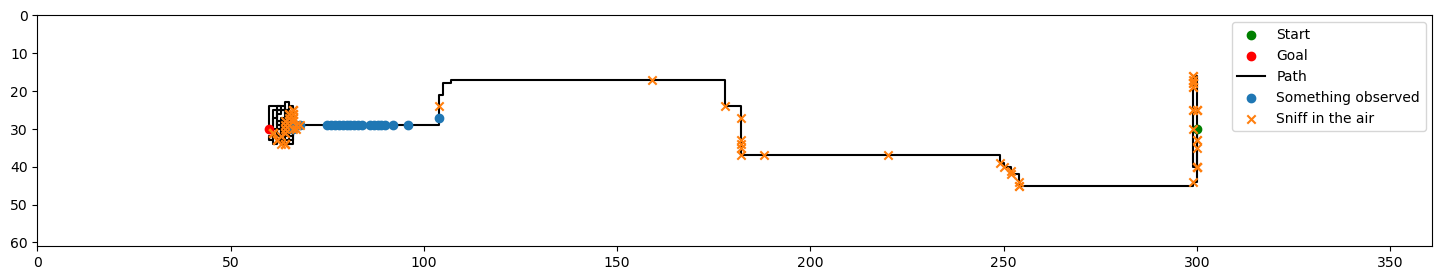

In [16]:
plot_steps(hist)

# Generate a vid

In [23]:
def plot_steps_mod(sim_hist:SimulationHistory, until_step:int=-1, ax=None) -> None:
    '''
    Plots a special version of the simulation plot for olfactory navigation
    
    Parameters
    ----------
    sim_hist : SimulationHistory
        The completed simulation history.
    ax : optional
        The ax the produce the plot on, if not a new one will be created.
    '''
    # Generate ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(18,3))

    # Initial clearing
    ax.clear()

    # Get cpu model
    model = sim_hist.model.cpu_model

    # Plot setup
    env_shape = model.cpu_model.state_grid.shape
    ax.set_xlim(0, env_shape[1])
    ax.set_ylim(env_shape[0], 0)

    # Start
    start_coord = sim_hist.grid_point_sequence[0]
    ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

    # Goal
    goal_coord = np.array([np.argwhere(model.state_grid == g)[0].tolist() for g in model.end_states])
    ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

    # Until step
    seq = np.array(sim_hist.grid_point_sequence)
    if until_step < 0:
        until_step = len(seq) - 1

    # Plot background
    if until_step < len(sim_hist.actions):
        if sim_hist.actions[until_step] == 5:
            ax.imshow(nose_resized[until_step], zorder=-2, alpha=0.7, cmap='Oranges')
        else:
            ax.imshow(ground_resized[until_step], zorder=-2, alpha=0.7, cmap='Blues')

    # Path
    ax.plot(seq[:until_step+1,1], seq[:until_step+1,0], zorder=-1, c='black', label='Path')

    # Something sensed
    something_obs_id = model.observation_labels.index('something')
    obs_ts = np.where(np.array(sim_hist.observations[:until_step]) == something_obs_id)
    points_obs = seq[obs_ts[0],:]
    ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

    # Points sniff
    sniff_air_action_id = -1
    for i, al in enumerate(model.action_labels):
        if 'air' in al.lower():
            sniff_air_action_id = i
    sniff_in_air = np.where(np.array(sim_hist.actions[:until_step]) == sniff_air_action_id)
    points_sniff = seq[sniff_in_air[0],:]
    if len(points_sniff) > 0:
        ax.scatter(points_sniff[:,1], points_sniff[:,0], zorder=2, marker='x', label='Sniff in the air')

    # Generate legend
    ax.legend(title=f'Frame: {until_step}', loc='upper right')

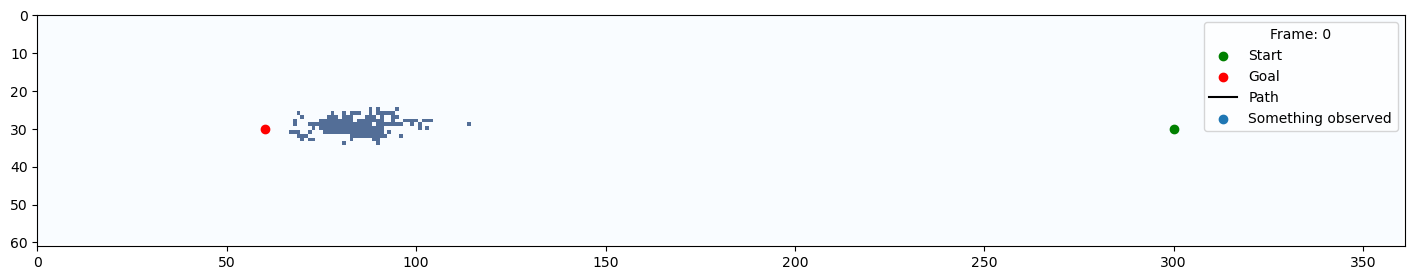

In [24]:
fig = plt.figure(figsize=(18,3))
ax = plt.gca()
steps = len(hist.states)

ani = animation.FuncAnimation(fig, (lambda frame_i: plot_steps_mod(hist, until_step=frame_i, ax=ax)), frames=steps, interval=1, repeat=False)

writervideo = animation.FFMpegWriter(fps=20)
ani.save('./Sim Videos/' + 'real_sim.mp4', writer=writervideo)